### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

### Importing the file

In [2]:
taxi_df = pd.read_csv('taxi_data.csv')

### Cleaning the data

In [3]:
taxi_df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


Checking the basic info about the dataset, we can see that there are **1,710,670** observations.


##### Dealing with duplicate rows and IDs

In [5]:
taxi_df.drop_duplicates(inplace=True)
taxi_df.shape  #2 duplicate rows were removed

(1710667, 9)

However, the column *TRIP_ID* has to be unique, so we have to make sure this requirement is satisfied.

In [6]:
len(taxi_df['TRIP_ID'].unique())

1710589

There are less unique ID's than rows, so there are still duplicates. We therefore inspect the data further by checking the duplicate rows.


In [7]:
trip_id_grp = taxi_df.groupby('TRIP_ID')
trip_id_grp['TRIP_ID'].count().sort_values(ascending=False).head(10)

TRIP_ID
1392499655620000663    2
1392640481620000663    2
1402586210620000400    2
1385772222620000263    2
1389561280620000080    2
1403407180620000242    2
1383341250620000588    2
1388279758620000080    2
1373210896620000598    2
1381645412620000328    2
Name: TRIP_ID, dtype: int64

The array above shows the frequencies of each ID, sorted in descending order (the output is limited to the first 10 IDs).

In [8]:
taxi_df[taxi_df['TRIP_ID'] == 1373210896620000598].sort_values('POLYLINE', key=(lambda col: col.str.len()), ascending=False)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
33350,1373210896620000598,C,NaN,NaN,20000598,1373210896,A,False,"[[-8.610813,41.14548],[-8.610732,41.145579],[-..."
33228,1373210896620000598,B,NaN,57.0,20000598,1373210896,A,False,"[[-8.610885,41.145525]]"


We choose a few of the duplicate IDs and look at the filtered data, like we did with the ID above. In most cases, the column that is different is **POLYLINE**, which should contain the GPS coordinates for the route. However, the value for this column is either missing or is incomplete in one of the records, so we keep the record that contains more GPS information.

In [9]:
taxi_df.sort_values('POLYLINE', key=(lambda col: col.str.len()), ascending=False, inplace=True) #sorts the data by the length of the POLYLINE in descending order
taxi_df.drop_duplicates(subset=['TRIP_ID'], keep='first', inplace=True) #only keep the first occurrence of the ID
taxi_df.sort_index(inplace=True)
taxi_df.shape

(1710589, 9)

#### Dealing with set-membership
We check if the values in each column fall within the expected values.

In [10]:
taxi_df.head(4)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."


In [11]:
print(taxi_df['CALL_TYPE'].unique()) #must contain A, B or C
print(taxi_df['DAY_TYPE'].unique()) #must contain A, B or C

['C' 'B' 'A']
['A']


The result above shows that the values of columns **CALL_TYPE** and **DAY_TYPE** fall within the expected values.

#### Dealing with datatypes

In [12]:
print(type(taxi_df.loc[0 ,'POLYLINE']))

<class 'str'>


We want each value of **POLYLINE** to be interpreted as a list of points, and NOT as a string. Therefore, we use a function that converts each value. However, due to memory limitations, it's difficult to apply this method to a large number of values without cloud computing. Therefore, two possible functions will be presented below in the form of comments.

In [13]:
# def polyline_to_list(string):
#     string = string.replace('[', '').replace( ']', '').split(',')
#     length = len(string)
#     output = []
#     for i in range(length // 2):
#         output.append([float(string[i]), float(string[i + 1])])
#     return output

#taxi_tf['POLYLINE'] = taxi_tf['POLYLINE'].apply(polyline_to_list)

or

In [14]:
# col = []
# for i in taxi_df.index:
#     col.append(eval(taxi_df.loc[i, 'POLYLINE']))
#taxi_tf['POLYLINE'] = col


#### Renaming data values

To better reflect the meaning, the values in some columns will be replaced with a more specific alternative.

In [15]:
taxi_df['CALL_TYPE'].replace({'A': 'central', 'B': 'stand', 'C': 'random street'}, inplace=True)
taxi_df['DAY_TYPE'].replace({'A': 'normal', 'B': 'holiday', 'C': 'before holiday'}, inplace=True)
taxi_df['ORIGIN_CALL'].replace({np.NAN: 'unknown'}, inplace=True)
taxi_df['ORIGIN_STAND'] = pd.to_numeric(taxi_df['ORIGIN_STAND'].replace({np.NAN: -1}), downcast='signed') #replace with a temporary column
taxi_df['ORIGIN_STAND'].replace({-1: 'no stand'}, inplace=True)

#### Adding additional related columns

We add a column for the starting time of the trip by converting the **TIMESTAMP** column to datetime.

In [16]:
taxi_df['STARTING_TIME'] = pd.to_datetime(taxi_df['TIMESTAMP'], unit='s')
taxi_df['STARTING_TIME'] = taxi_df['STARTING_TIME'] + pd.Timedelta(1, 'hour') #converting from UTC to Portugal time
taxi_df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,STARTING_TIME
0,1372636858620000589,random street,unknown,no stand,20000589,1372636858,normal,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 01:00:58
1,1372637303620000596,stand,unknown,7,20000596,1372637303,normal,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 01:08:23
2,1372636951620000320,random street,unknown,no stand,20000320,1372636951,normal,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 01:02:31
3,1372636854620000520,random street,unknown,no stand,20000520,1372636854,normal,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 01:00:54
4,1372637091620000337,random street,unknown,no stand,20000337,1372637091,normal,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 01:04:51


Next, we can add a column for the duration of the trip, using the fact that the geographical data was recorded every 15 seconds.
Since **POLYLINE** is a string and it's too costly to change it to a list of lists whose length we can compute, we can substract 1 from the times the character "[" appears in each cell to find the number of points.

In [17]:
temp_column = taxi_df['POLYLINE'].apply(lambda value: (value.count('[') - 1) * 15) #data was recorded every 15 seconds
taxi_df['TRIP_DURATION'] = pd.to_timedelta(temp_column, unit='S')
del temp_column
taxi_df.head()


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,STARTING_TIME,TRIP_DURATION
0,1372636858620000589,random street,unknown,no stand,20000589,1372636858,normal,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 01:00:58,0 days 00:05:45
1,1372637303620000596,stand,unknown,7,20000596,1372637303,normal,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 01:08:23,0 days 00:04:45
2,1372636951620000320,random street,unknown,no stand,20000320,1372636951,normal,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 01:02:31,0 days 00:16:15
3,1372636854620000520,random street,unknown,no stand,20000520,1372636854,normal,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 01:00:54,0 days 00:10:45
4,1372637091620000337,random street,unknown,no stand,20000337,1372637091,normal,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 01:04:51,0 days 00:07:15


In [18]:
taxi_df['ENDING_TIME'] = taxi_df['STARTING_TIME'] + taxi_df['TRIP_DURATION']
taxi_df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,STARTING_TIME,TRIP_DURATION,ENDING_TIME
0,1372636858620000589,random street,unknown,no stand,20000589,1372636858,normal,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 01:00:58,0 days 00:05:45,2013-07-01 01:06:43
1,1372637303620000596,stand,unknown,7,20000596,1372637303,normal,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 01:08:23,0 days 00:04:45,2013-07-01 01:13:08
2,1372636951620000320,random street,unknown,no stand,20000320,1372636951,normal,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 01:02:31,0 days 00:16:15,2013-07-01 01:18:46
3,1372636854620000520,random street,unknown,no stand,20000520,1372636854,normal,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 01:00:54,0 days 00:10:45,2013-07-01 01:11:39
4,1372637091620000337,random street,unknown,no stand,20000337,1372637091,normal,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 01:04:51,0 days 00:07:15,2013-07-01 01:12:06


#### Checking for valid paths

There are some paths described in the **POLYLINE** column that might contain invalid points. We will apply a rather rudimentary method for filtering them out. 

Considering that the geographical location was recorded every 15 seconds, we can filter out the paths that cover unrealistic distances in that time. 
Assuming a rather high maximum speed of $150km/h$, a taxi can travel at most 625 meters in 15 seconds. So, any consecutive points with a distance larger than 625 meters from one another can be used to mark the path as invalid. 

Given two points $A(lat_1, lon_1), B(lat_2, lon_2)$, the distance between them can be calculated as follows:

$\Delta lat = (lat_2 - lat_1) \cdot \dfrac{\pi}{180}$

$\Delta lon = (lon_2 - lon_1) \cdot \dfrac{\pi}{180}$

$a=\sin(\Delta lat / 2)^2 + \cos(lat_1)\cdot\cos(lat_2)\cdot\sin(\Delta lon / 2)^2$

$c = 2\cdot\arcsin(\sqrt{a})$

$distance = c \cdot r$, where $r = 6371$ (Earth's radius in km).

We can turn this into a function.

In [19]:
def distance(lat1, lat2, lon1, lon2, unit='km'): #returns distance in km by default
    r = 6371 #radius of the Earth in km

    lat1 *= math.pi / 180
    lat2 *= math.pi / 180
    lon1 *= math.pi / 180
    lon2 *= math.pi / 180

    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    
    a = math.sin(d_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2)**2

    c = 2 * math.asin(math.sqrt(a))
    if unit == 'km':
        return c * r
    elif unit== 'm':
        return c * r * 1000

In [20]:
def is_path_valid(path):
    path = eval(path)
    if len(path) < 2: #we treat paths with less than 2 points as invalid
        return False
    for i in range(len(path) - 1):
        lat1 = path[i][1]
        lat2 = path[i + 1][1]
        lon1 = path[i][0]
        lon2 = path[i + 1][0]
        dist = distance(lat1, lat2, lon1, lon2, unit='m')
        if dist > 625:
            return False
    return True

We create a column indicating which paths are valid.

In [21]:
for index in taxi_df.index:
    taxi_df.at[index, 'IS_PATH_VALID'] = is_path_valid(taxi_df.at[index, 'POLYLINE']) 

We can check for the percentage of valid and invalid paths.

In [22]:
taxi_df['IS_PATH_VALID'].value_counts() / sum(taxi_df['IS_PATH_VALID'].value_counts()) * 100 

True     87.64449
False    12.35551
Name: IS_PATH_VALID, dtype: float64

As seen above, there is a significant amount of paths that are invalid (around 12%). 
To have a better idea what goes wrong, we can plot some invalid paths. To do this, we first define a function that plots a path and marks the invalid sections.

In [23]:
def plot_path(path, title=''):
    path_as_df = pd.DataFrame(eval(path), columns=['longitude', 'latitude']) #put longitudes and latitudes in separate columns
    padding = 0.005 #extend the borders of the map
    plt.figure(dpi=75, figsize=(12,12))
    m = Basemap(llcrnrlon=path_as_df['longitude'].min() - padding, llcrnrlat=path_as_df['latitude'].min() - padding, 
                urcrnrlon=path_as_df['longitude'].max() + padding, urcrnrlat=path_as_df['latitude'].max() + padding,
                epsg=3763)
    m.arcgisimage(service='World_Topo_Map', xpixels = 2000, verbose= True)

    #go through all consecutive pair of points and check distance between them and plot
    for i in range(path_as_df.shape[0] - 1):
        lon1, lon2 = path_as_df.loc[i:i+1, 'longitude'] #extract longitudes
        lat1, lat2 = path_as_df.loc[i:i+1, 'latitude'] #extract latitudes
        x_coords, y_coords = m([lon1, lon2], [lat1, lat2]) #convert to 2d coordinates
        if distance(lat1, lat2, lon1, lon2, unit='m') > 625: #color large distances between points as red
            m.plot(x_coords, y_coords, color='#ed3a1a', label='long jumps (>650m)')
        else:
            m.plot(x_coords, y_coords, color='#1650b5', label='rest of the path')

    #plot the starting and the ending points
    x_coords_start, y_coords_start = m(path_as_df.iloc[0, 0], path_as_df.iloc[0, 1])
    x_coords_end, y_coords_end = m(path_as_df.iloc[-1, 0], path_as_df.iloc[-1, 1])
    m.plot(x_coords_start, y_coords_start, 'go', markersize=10)
    m.plot(x_coords_end, y_coords_end, 'o', markersize=10, color='orange')

    #create custom legend
    legend_elements = [plt.Line2D([0], [0], color='#ed3a1a', lw=4, label='long jumps (>650m)'),
                    plt.Line2D([0], [0], color='#1650b5', lw=4, label='rest of the path'),
                    plt.Line2D([0], [0], marker='o', linewidth=0, color='w', label='starting point',
                                            markerfacecolor='g', markersize=12),
                    plt.Line2D([0], [0], marker='o', linewidth=0, color='w', label='ending point',
                                            markerfacecolor='orange', markersize=12)]
    plt.title(title)
    plt.legend(handles=legend_elements)

We check the first few indices of the invalid paths and choose one of them to plot.

In [24]:
taxi_df[taxi_df['IS_PATH_VALID'] == False].index[0:5] #first 5 indices

Int64Index([2, 3, 15, 54, 57], dtype='int64')

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-43852.80114619862,163032.83179888464,-38476.315448554655,165693.44721959843&bboxSR=3763&imageSR=3763&size=2000,989&dpi=96&format=png32&transparent=true&f=image


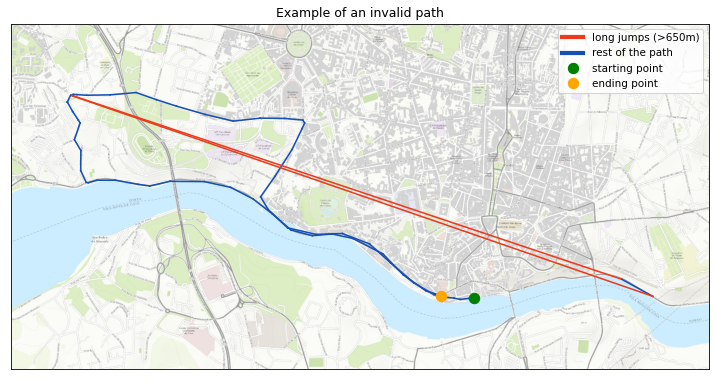

In [25]:
plot_path(taxi_df['POLYLINE'][2], title='Example of an invalid path') #plot the path for index 2

As seen above, the coordinates are wrong for some of the points.

### Analysis

We will now take a look at some specific metrics such as:
* Distribution of the trip duration
* Frequency of each call type
* Busiest times of the day
* ... and more

#### What about the trip duration?

In [26]:
filt = (taxi_df['MISSING_DATA'] == False)  #only consider the observations where there is data
trip_minutes = taxi_df.loc[filt, 'TRIP_DURATION'].apply(lambda x: x.seconds / 60) #get trip duration in minutes

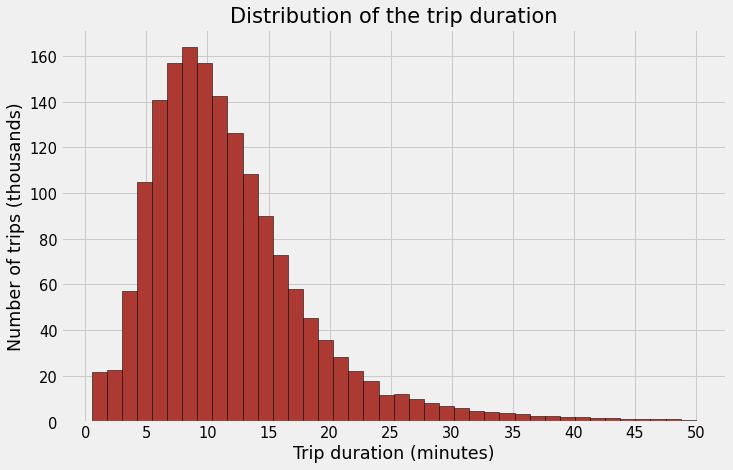

In [27]:
plt.style.use('fivethirtyeight')
plt.figure(dpi=75, figsize=(10, 6.5))
plt.hist(trip_minutes, bins = 40, range=(0.5,50), color='#ad3a32', edgecolor='black')
plt.title('Distribution of the trip duration')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips (thousands)')
plt.gca().set_xticks(np.arange(0, 51, 5))
plt.gca().set_yticklabels((np.arange(0, 180, 20)))
plt.tight_layout()

The graph above excludes outliers (trips shorter than 30 seconds or longer than 50 minutes).

In [28]:
taxi_df['TRIP_DURATION'].median()

Timedelta('0 days 00:10:15')

The median trip duration is around 10 minutes. 

#### Frequency of each call type

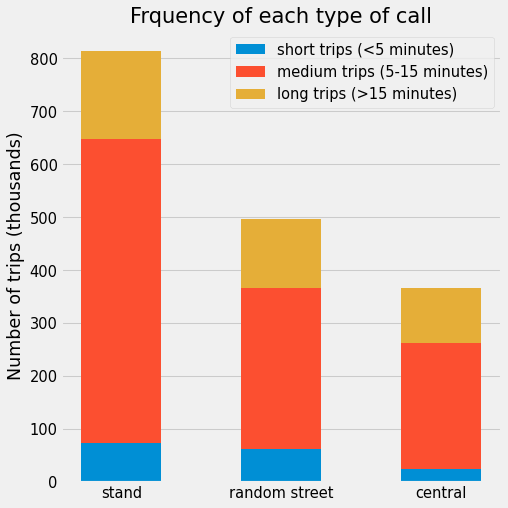

In [29]:
filt = np.logical_and(taxi_df['TRIP_DURATION'] >= pd.Timedelta(0.5, unit='m'), 
                      taxi_df['TRIP_DURATION'] <= pd.Timedelta(50, unit='m'))
temp_df = taxi_df[filt] #exclude outliers

#short trips (<5 minutes)
filt1 = (temp_df['TRIP_DURATION'] < pd.Timedelta(5, unit='m'))
freq_call_type_s = temp_df[filt1].groupby('CALL_TYPE')['CALL_TYPE'].count().sort_values(ascending=False)
#medium trips (5-15 minutes)
filt2 = (np.logical_and(temp_df['TRIP_DURATION'] >= pd.Timedelta(5, unit='m'), 
                        temp_df['TRIP_DURATION'] <= pd.Timedelta(15, unit='m')))
freq_call_type_m = temp_df[filt2].groupby('CALL_TYPE')['CALL_TYPE'].count().sort_values(ascending=False)
#long trips (>15 minutes)
filt3 = (temp_df['TRIP_DURATION'] >= pd.Timedelta(15, unit='m'))
freq_call_type_l = temp_df[filt3].groupby('CALL_TYPE')['CALL_TYPE'].count().sort_values(ascending=False)

width = 0.5
plt.style.use('fivethirtyeight')
plt.figure(dpi=75, figsize=(7, 7))
plt.bar(x=freq_call_type_s.index, height=freq_call_type_s / 1000,
        width=width, label='short trips (<5 minutes)')
plt.bar(x=freq_call_type_m.index, height=freq_call_type_m / 1000,
        width=width, bottom=freq_call_type_s / 1000, label='medium trips (5-15 minutes)')
plt.bar(x=freq_call_type_l.index, height=freq_call_type_l / 1000,
        width=width, bottom=freq_call_type_m / 1000 + freq_call_type_s / 1000, label='long trips (>15 minutes)')
plt.title('Frquency of each type of call')
plt.ylabel('Number of trips (thousands)')
plt.gca().xaxis.grid(False)
plt.legend()
plt.tight_layout()

Most people get taxies from the stand regardless of the expected trip duration. 

#### Busiest days of the week

In [30]:
# weekday_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekday_freq = taxi_df['STARTING_TIME'].dt.day_of_week.value_counts().sort_index(ascending=False)
weekday_freq.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][-1::-1]
weekday_freq

Sunday       236225
Saturday     258188
Friday       273823
Thursday     246372
Wednesday    231892
Tuesday      234819
Monday       229270
Name: STARTING_TIME, dtype: int64

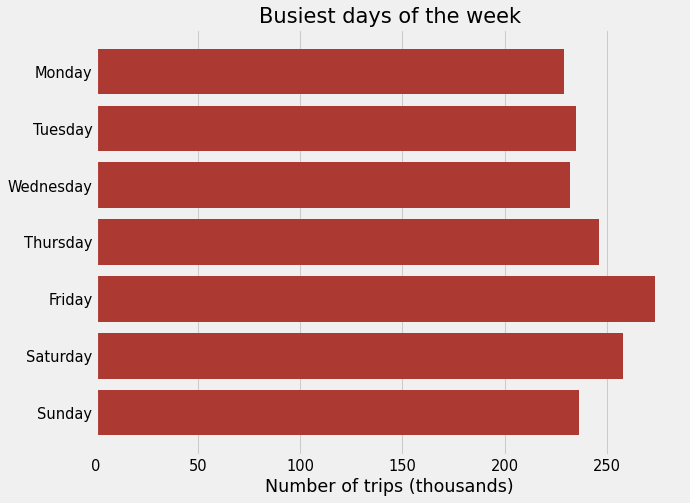

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(dpi=75, figsize=(9, 7))
plt.barh(y=weekday_freq.index, width=weekday_freq / 1000, color='#ad3a32')
plt.title('Busiest days of the week')
plt.xlabel('Number of trips (thousands)')
plt.gca().yaxis.grid(False)

Friday seems to be the busiest day of the week.

### Busiest months of the year

In [32]:
month_freq = taxi_df['STARTING_TIME'].dt.month.value_counts().sort_index()
month_freq.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_freq = month_freq[-1::-1]

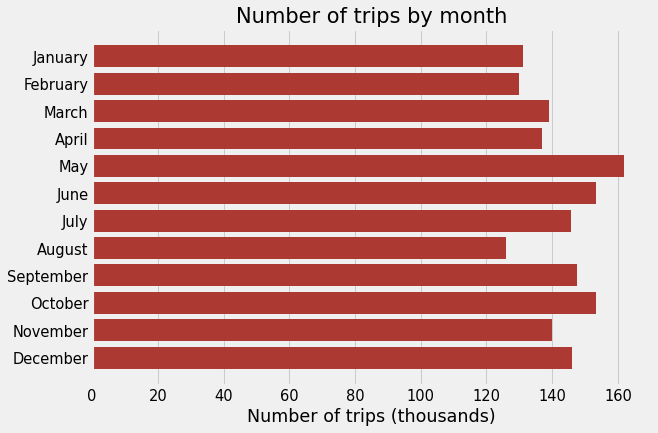

In [33]:
plt.figure(dpi=75, figsize=(9,6))
plt.barh(y=month_freq.index, width=month_freq / 1000, color='#ad3a32')
plt.xlabel('Number of trips (thousands)')
plt.title('Number of trips by month');
plt.gca().yaxis.grid(False)
plt.tight_layout()

#### Number of trips for each stand

In [34]:
stand_df = taxi_df.groupby('ORIGIN_STAND')['ORIGIN_STAND'].count()
stand_df = pd.DataFrame(stand_df)
stand_df.drop('no stand', inplace=True)
stand_df.columns = ['FREQUENCY']

temp = np.logical_and(taxi_df['IS_PATH_VALID'] == True, 
                      taxi_df['CALL_TYPE'] == 'stand') #only consider valid paths that are labeled as stands
for stand in stand_df.index:
    filt = np.logical_and(taxi_df['ORIGIN_STAND'] == stand, temp) #narrow down the search by stand number
    lon_list = pd.Series()
    lat_list = pd.Series()
    #check 5 different observations for each stand and take the median coordinates to eliminate possible mistakes
    for i in range(5):
        lon, lat = eval(taxi_df.loc[filt, 'POLYLINE'].iloc[i])[0]
        lon_list = lon_list.append(pd.Series([lon]))
        lat_list = lat_list.append(pd.Series([lat]))
    coord = [lon_list.median(), lat_list.median()]
    stand_df.loc[stand, ['LONGITUDE', 'LATITUDE']] = coord


In [35]:
stand_df.head() #check the first few rows

,FREQUENCY,LONGITUDE,LATITUDE
ORIGIN_STAND,,,
1,4518,-8.609400,41.177268
2,1191,-8.591283,41.156190
3,3558,-8.665623,41.170707
4,1153,-8.621640,41.143752
5,53,-8.613099,41.183406


We can plot all the stands on the map, along with the number of trips. Each dot is a stand. The color and size of each dot is directly proportional to the number of trips.

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-47122.293181259694,163099.14876530226,-36096.82865198028,168890.8390416591&bboxSR=3763&imageSR=3763&size=2000,1050&dpi=96&format=png32&transparent=true&f=image


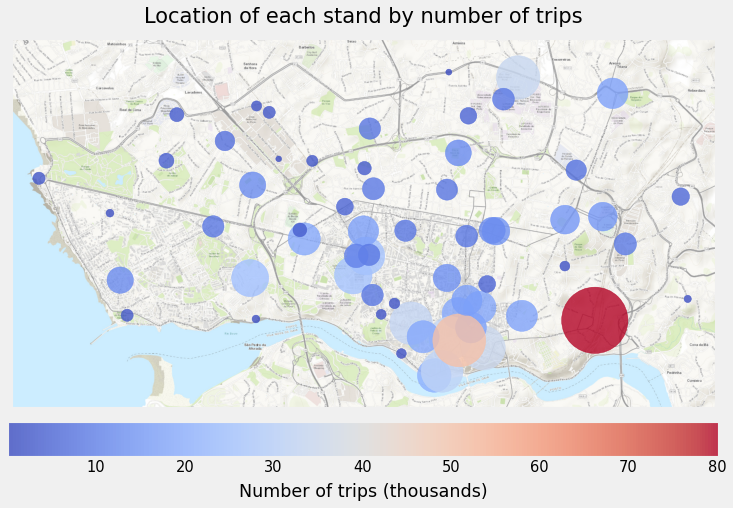

In [36]:
plt.figure(dpi=75, figsize=(13,7))
padding = 0.005
map = Basemap(llcrnrlon=stand_df['LONGITUDE'].min() - padding, llcrnrlat=stand_df['LATITUDE'].min() - padding,
              urcrnrlon=stand_df['LONGITUDE'].max() + padding, urcrnrlat=stand_df['LATITUDE'].max() + padding,
              epsg=3763)
map.arcgisimage(service='World_Topo_Map', xpixels = 2000, verbose= True)
xcoords, ycoords = map(stand_df['LONGITUDE'], stand_df['LATITUDE'])
plt.scatter(x=xcoords, y=ycoords, s=stand_df['FREQUENCY'] / 20 + 30, c=stand_df['FREQUENCY'] / 1000, cmap='coolwarm', alpha=0.8);
plt.colorbar(orientation="horizontal", pad=0.03, fraction=0.085)
plt.title('Location of each stand by number of trips', pad=14)
plt.gca().xaxis.set_label_coords(0, -0.2)
plt.xlabel('Number of trips (thousands)')
plt.tight_layout()

In [37]:
# taxi_df[taxi_df['IS_PATH_VALID'] == True].groupby('TAXI_ID')['TAXI_ID'].count() / taxi_df.groupby('TAXI_ID')['TAXI_ID'].count()
# pd.merge(left=taxi_df[taxi_df['IS_PATH_VALID'] == True].groupby('TAXI_ID')['TAXI_ID'].count() / taxi_df.groupby('TAXI_ID')['TAXI_ID'].count(), right=taxi_df.groupby('TAXI_ID')['TAXI_ID'].count(), left_index=True, right_index=True).sort_values('TAXI_ID_x').dropna()

We can go even further by plotting the location of all the stands on top of a density map for the starting points (trips starting at a stand are not included).

In [38]:
filt = np.logical_and(taxi_df['IS_PATH_VALID'] == True, 
                      taxi_df['CALL_TYPE'] != 'stand')
nrows = taxi_df[filt].shape[0] #number of rows
#initializing the columns
starting_points = pd.DataFrame({'longitude' : [0] * nrows, 'latitude': [0] * nrows})
i = 0
for index in taxi_df[filt].index: #only go through valid paths that didn't start from a stand
    point = eval(taxi_df.at[index, 'POLYLINE'])[0] #take the starting point
    #split the point into longitude and latitude
    starting_points.iat[i, 0] = point[0] 
    starting_points.iat[i, 1] = point[1]
    i += 1


In [39]:
starting_points.head()

,longitude,latitude
0,-8.618643,41.141412
1,-8.645994,41.180490
2,-8.615502,41.140674
3,-8.579520,41.145948
4,-8.617563,41.146182


To create the visualization below, dataframes **starting_points** and **stand_df** were used, by importing them into Tableau. The legend was later added in Photoshop.

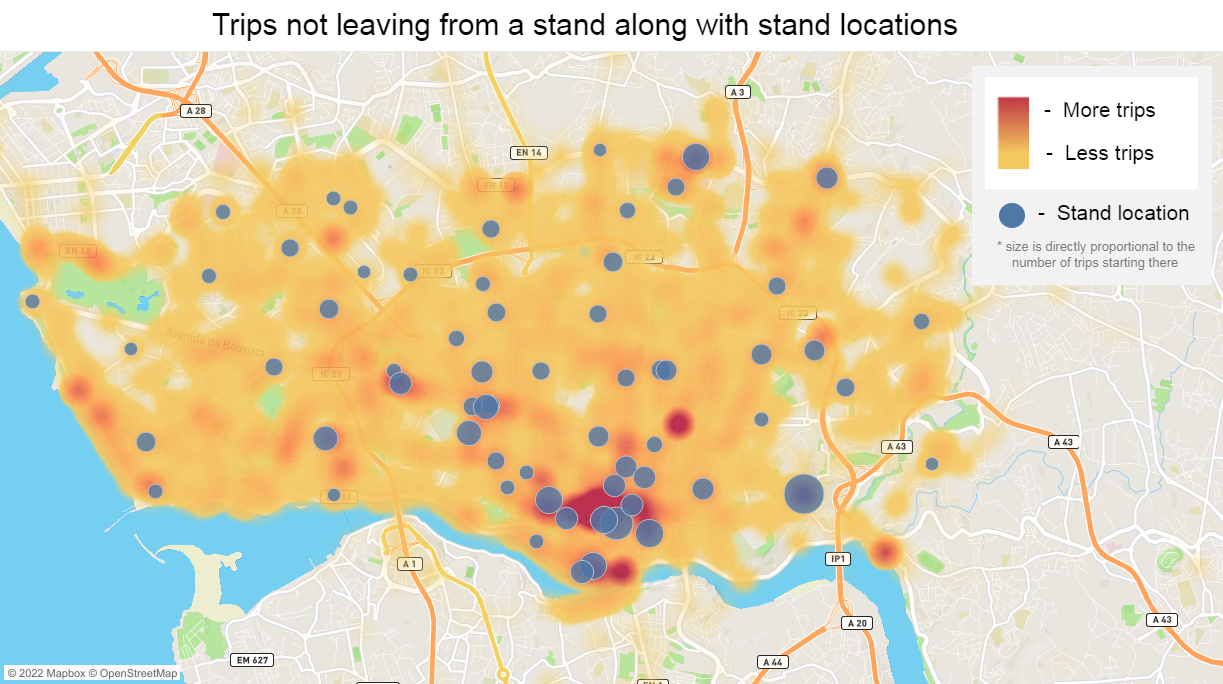

In [40]:
Image("Images/tableau map.png", width=948, height=526)

As it can be seen, there are several areas where the number of trips is relatively high, while there are no stands nearby. If we assume that the number of these trips is directly proportional to the population and that, as shown earlier, people prefer stands, then creating more stands in those parts of the city might increase the overall number of trips.

However, to make a solid and data-driven decision, more data is necessary, such as the population density map of the city. 